# Classification of Kannada MNIST
##  ![Preamble of kannada digits](img/kannada_numbers.jpg)


In [1]:
# Author: Vikas Chidananda 

# Dataset credits: Vinay Uday Prabhu
# Prabhu, V. (2019, August 03). Kannada-MNIST: A new handwritten DIGITS dataset 
#     for the Kannada language. Retrieved April 19, 2021, 
#     from https://arxiv.org/abs/1908.01242v1

In [2]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt 

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tqdm import tqdm

In [3]:
path_test_data = 'Kannada-MNIST_data/test.csv'
path_train_data = 'Kannada-MNIST_data/train.csv'
df_test = pd.read_csv(path_test_data)
df_train = pd.read_csv(path_train_data)

In [4]:
df_train.head()
df_test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
labels, data = df_train['label'].to_numpy(), df_train.iloc[:, 1:].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(
                                                                data, labels, test_size = 0.05, random_state = 1)

In [6]:
num_components, num_data = len(np.unique(train_labels)), train_data.shape[0]
# normalize the data
train_data = train_data/255.0
test_data = test_data/255.0

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(57000, 784) (57000,)
(3000, 784) (3000,)


In [7]:
# store data as images
test_labels

array([1, 5, 6, ..., 2, 0, 2], dtype=int64)

In [156]:
def print_misclssified(predictions, true_labels):
    idxs = np.where(predictions != true_labels)
    idxs = idxs[0]
    num = len(idxs)
    print(num)
    n = int(np.sqrt(num)) + 1
    print(n)
    plt.figure(figsize=(20,20))
    
    for i in range(num):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])

        image_ind = idxs[i]
        digit = test_data[image_ind]
        plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
    #     print(train_labels[image_ind])
        plt.xlabel('true:'+str(true_labels[image_ind])+' pred:'+str(predictions[image_ind] ))
    

## Visualize some of the data

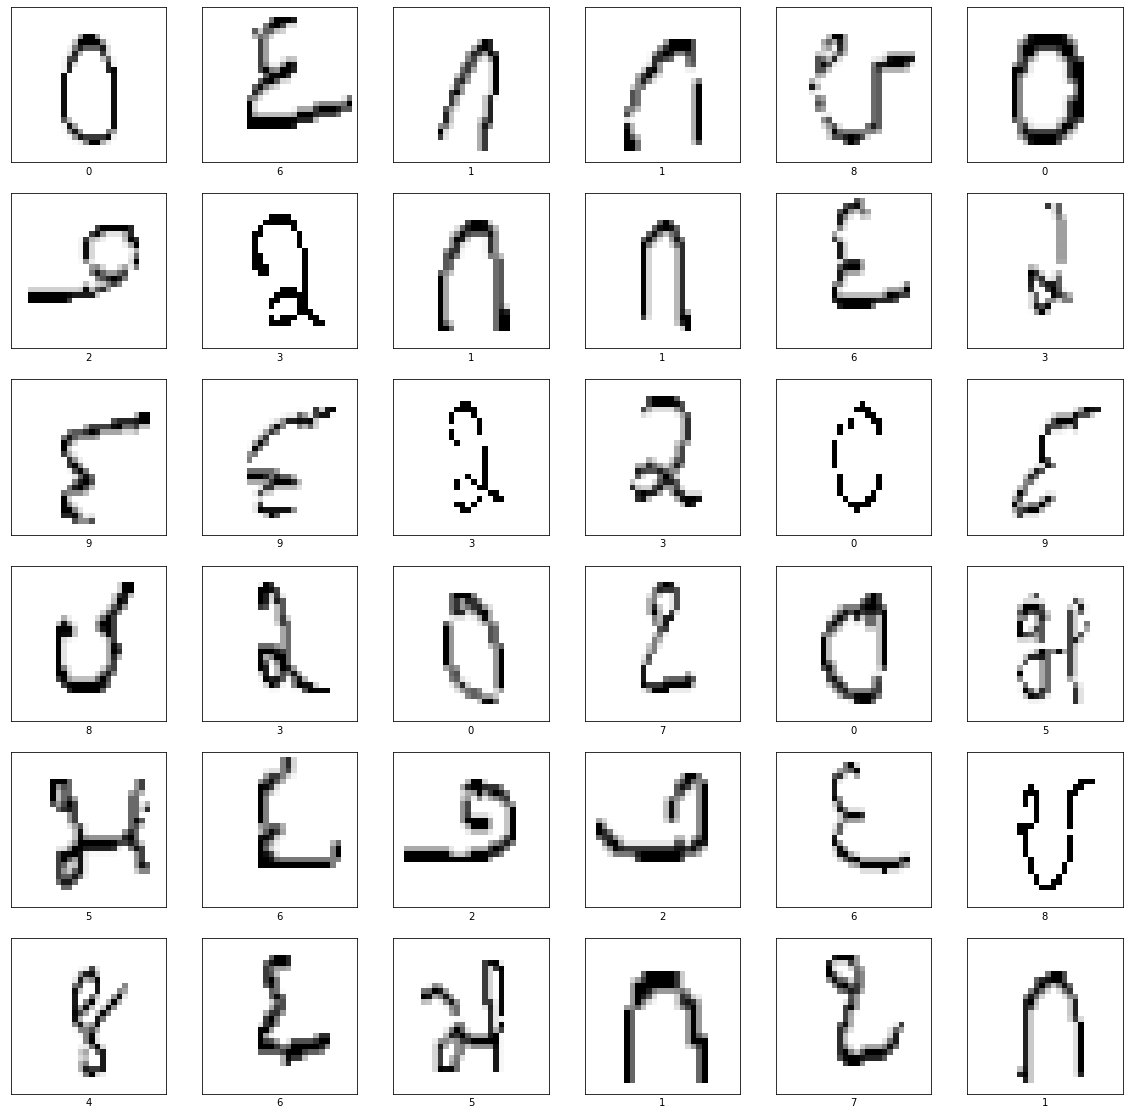

In [8]:
plt.figure(figsize=(20,20))
random_inds = np.random.choice(48000,36)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    digit = train_data[image_ind]
    plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
#     print(train_labels[image_ind])
    plt.xlabel(train_labels[image_ind])

In [ ]:
# To do improve image quality - discontinuity


### LDA and SVM

In [10]:
# Since most of the data is empty (0's) let's use LDA to reduce the data space
clf_lda = LDA()
%timeit clf_lda.fit(train_data, train_labels)

14.7 s ± 311 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
print(f'Score on trained data: {clf_lda.score(train_data, train_labels)}')
print(f'Score on test data: {clf_lda.score(test_data, test_labels)}')

Score on trained data: 0.9351403508771929
Score on test data: 0.9206666666666666


In [42]:
test_data_reduced = clf_lda.transform(test_data)
train_data_reduced = clf_lda.transform(train_data)

clf_reduced = LDA()
clf_reduced.fit(train_data_reduced, train_labels)

print(f'Score on trained data: {clf_reduced.score(train_data_reduced, train_labels)}')
print(f'Score on test data: {clf_reduced.score(test_data_reduced, test_labels)}')
predicted = clf_reduced.predict(test_data_reduced)

Score on trained data: 0.9351403508771929
Score on test data: 0.9206666666666666


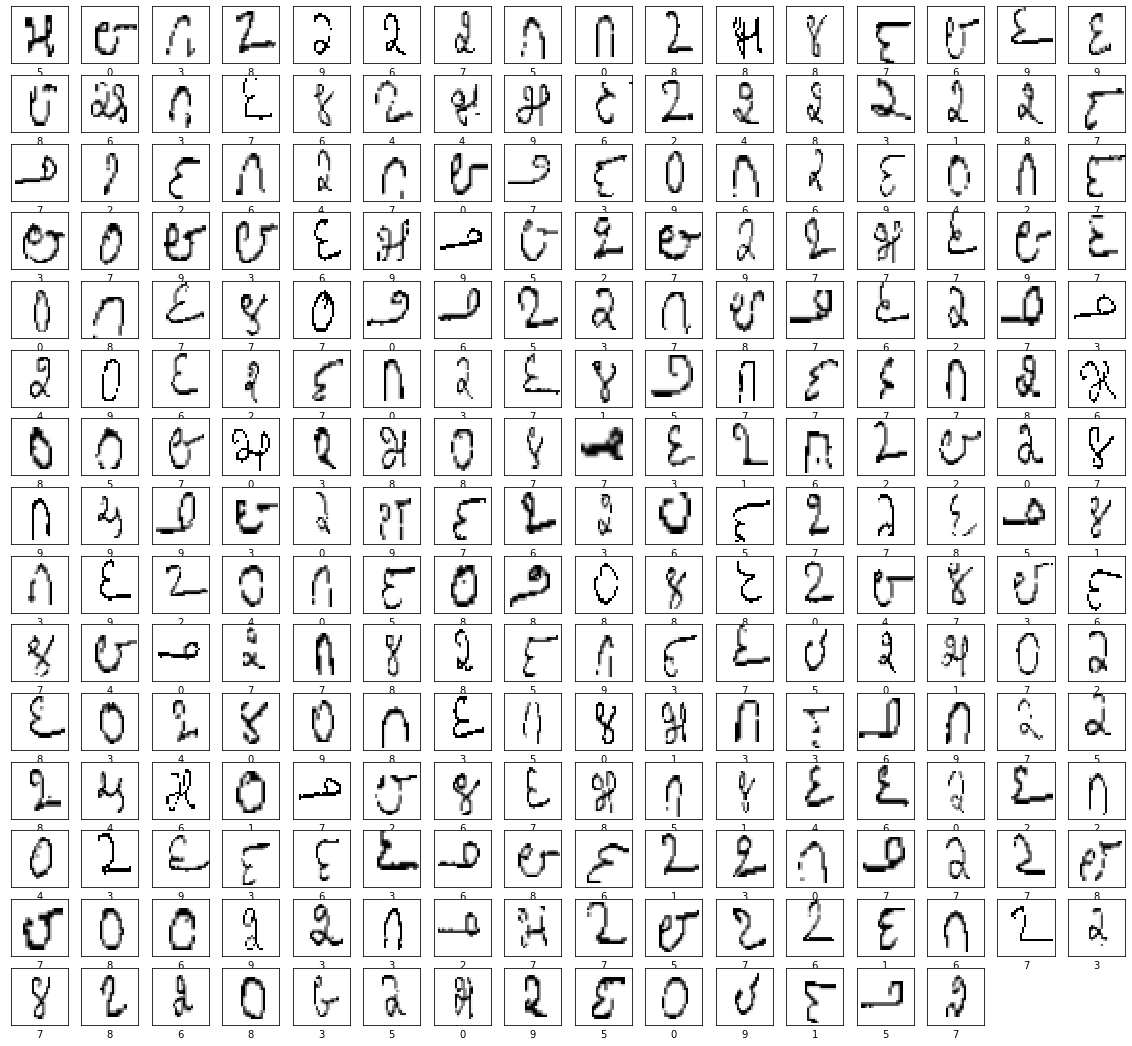

In [108]:
misclassified = np.where(predicted != test_labels)
print_misclssified(misclassified[0], test_labels)

In [25]:
clf_svm = svm.LinearSVC(C = 0.01,
                penalty='l2',
                loss='squared_hinge',
                tol=0.0001,
                multi_class='ovr')
clf_svm.fit(train_data, train_labels) 
      
clf_svm.score(test_data, test_labels)

0.9553333333333334

### Deeplearning (NN) with different architectures

In [26]:
def build_model():                                                 #layers as arguments
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return nn_model

model = build_model()

In [27]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])


In [28]:
batch_size = 32
epochs = 5

model.fit(train_data, train_labels, batch_size = batch_size, epochs = epochs)

Epoch 1/5
1782/1782 [==============================] - 17s 7ms/step - loss: 0.1866 - accuracy: 0.9465
Epoch 2/5
1782/1782 [==============================] - 13s 7ms/step - loss: 0.0769 - accuracy: 0.9772
Epoch 3/5
1782/1782 [==============================] - 13s 7ms/step - loss: 0.0525 - accuracy: 0.9844
Epoch 4/5
1782/1782 [==============================] - 13s 7ms/step - loss: 0.0389 - accuracy: 0.9888
Epoch 5/5
1782/1782 [==============================] - 12s 7ms/step - loss: 0.0290 - accuracy: 0.9918


In [29]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

print('Test accuracy:', test_acc, test_loss)

94/94 - 1s - loss: 0.0481 - accuracy: 0.9847
Test accuracy: 0.984666645526886 0.04809368774294853


In [30]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis = -1)
predictions

array([1, 5, 6, ..., 2, 0, 2], dtype=int64)

In [31]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

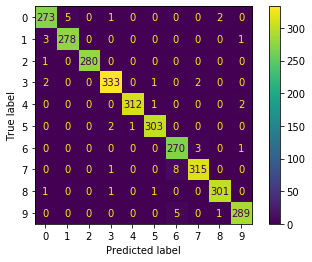

In [32]:
cm = confusion_matrix(test_labels, predictions, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

In [33]:
#print misclassified digits
idxs = np.where(predictions != test_labels)
idxs = np.array(idxs, dtype = int)
idxs[0]

array([   7,   47,   50,  140,  247,  251,  588,  693,  714,  778,  790,
        915,  919, 1048, 1070, 1157, 1195, 1264, 1275, 1310, 1336, 1396,
       1415, 1416, 1473, 1517, 1534, 1751, 1760, 1782, 1879, 1886, 2035,
       2045, 2064, 2075, 2134, 2258, 2289, 2324, 2336, 2784, 2886, 2941,
       2959, 2964])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
_________________________________________________________________


46
7


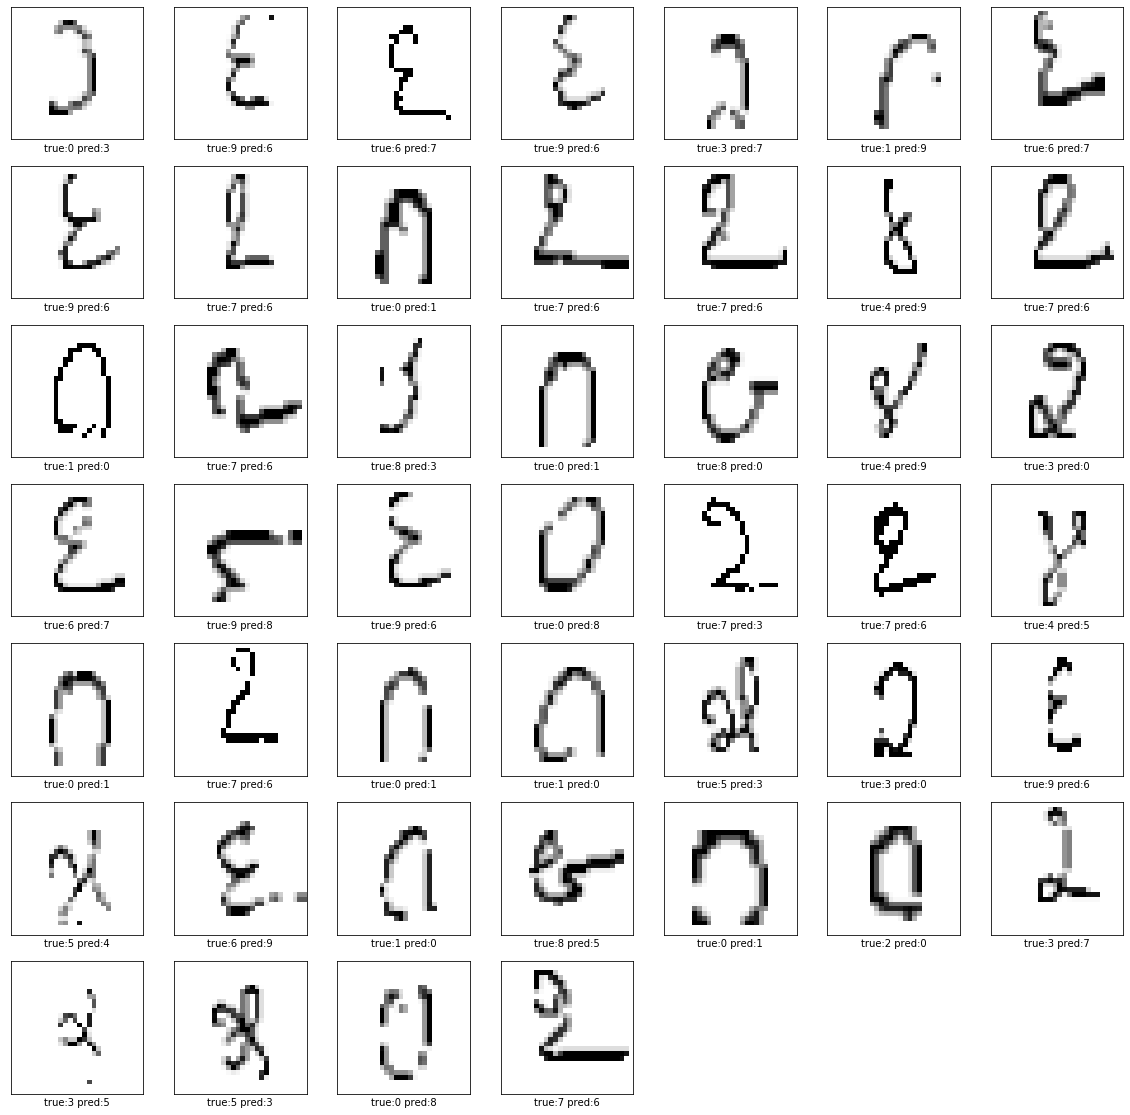

In [158]:
prediction_nn = np.argmax(model.predict(test_data), axis = -1)
print_misclssified(prediction_nn, test_labels)

In [107]:
#histograms of wrongly predicted labels
counts = ...

#### CNN with different architecture

2

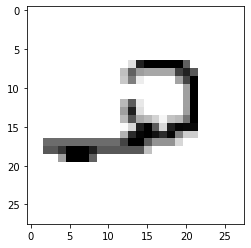

In [78]:
#resize the data to image
train_image = train_data.reshape(train_data.shape[0],28,28)
plt.imshow(train_image[0], cmap=plt.cm.binary)
train_labels[0]

In [79]:
i, x, y = train_image.shape
train_image = train_image.reshape(i, x, y, 1)

In [76]:
train_image.shape

(1, 57000, 28, 28)

In [80]:
def CNN_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(24, 3, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Conv2D(36, 2, activation = 'relu'),
        tf.keras.layers.MaxPool2D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return cnn_model

In [81]:
cnn_model = CNN_model()
cnn_model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])

In [82]:
batch = 64
epochs = 5

cnn_model.fit(train_image, train_labels, 
              batch_size = batch, 
              epochs=epochs)

Epoch 1/5
891/891 [==============================] - 29s 10ms/step - loss: 0.2124 - accuracy: 0.9337
Epoch 2/5
891/891 [==============================] - 8s 10ms/step - loss: 0.0586 - accuracy: 0.9826
Epoch 3/5
891/891 [==============================] - 8s 9ms/step - loss: 0.0384 - accuracy: 0.9881
Epoch 4/5
891/891 [==============================] - 9s 10ms/step - loss: 0.0296 - accuracy: 0.9910
Epoch 5/5
891/891 [==============================] - 9s 10ms/step - loss: 0.0238 - accuracy: 0.9927


In [83]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 24)        240       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 36)        3492      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 36)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1296)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               166016    
_________________________________________________________________
dense_12 (Dense)             (None, 10)               

In [86]:
test_data.shape[0]

3000

In [92]:
test_image = test_data.reshape(3000, 28, 28, 1)

In [93]:
test_loss, test_acc = cnn_model.evaluate(test_image, test_labels)

print(f'test accuracy : {test_acc} \t test loss: {test_loss}')

94/94 [==============================] - 1s 7ms/step - loss: 0.0348 - accuracy: 0.9887
test accuracy : 0.9886666536331177 	 test loss: 0.034782908856868744


In [124]:
#what did we classify wrongly?
predictions = cnn_model.predict(test_image)
predictions = np.argmax(predictions, axis = -1)
idxs = np.where(predictions != test_labels)
misclassified_labels = predictions[idxs]

In [125]:
misclassified_labels
idxs

(array([   1,    7,   47,  134,  140,  247,  251,  536,  693,  790,  844,
         883, 1070, 1118, 1157, 1195, 1215, 1247, 1264, 1351, 1416, 1493,
        1653, 1760, 1879, 1886, 1970, 2064, 2258, 2336, 2472, 2575, 2784,
        2941], dtype=int64),)

In [154]:
test_image[0,:,:,0].shape

(28, 28)

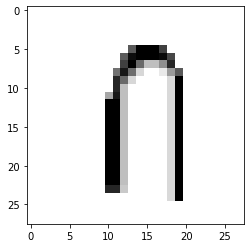

In [155]:
test_labels[7]
plt.imshow(test_image[0,:,:,0], cmap=plt.cm.binary)

34
6


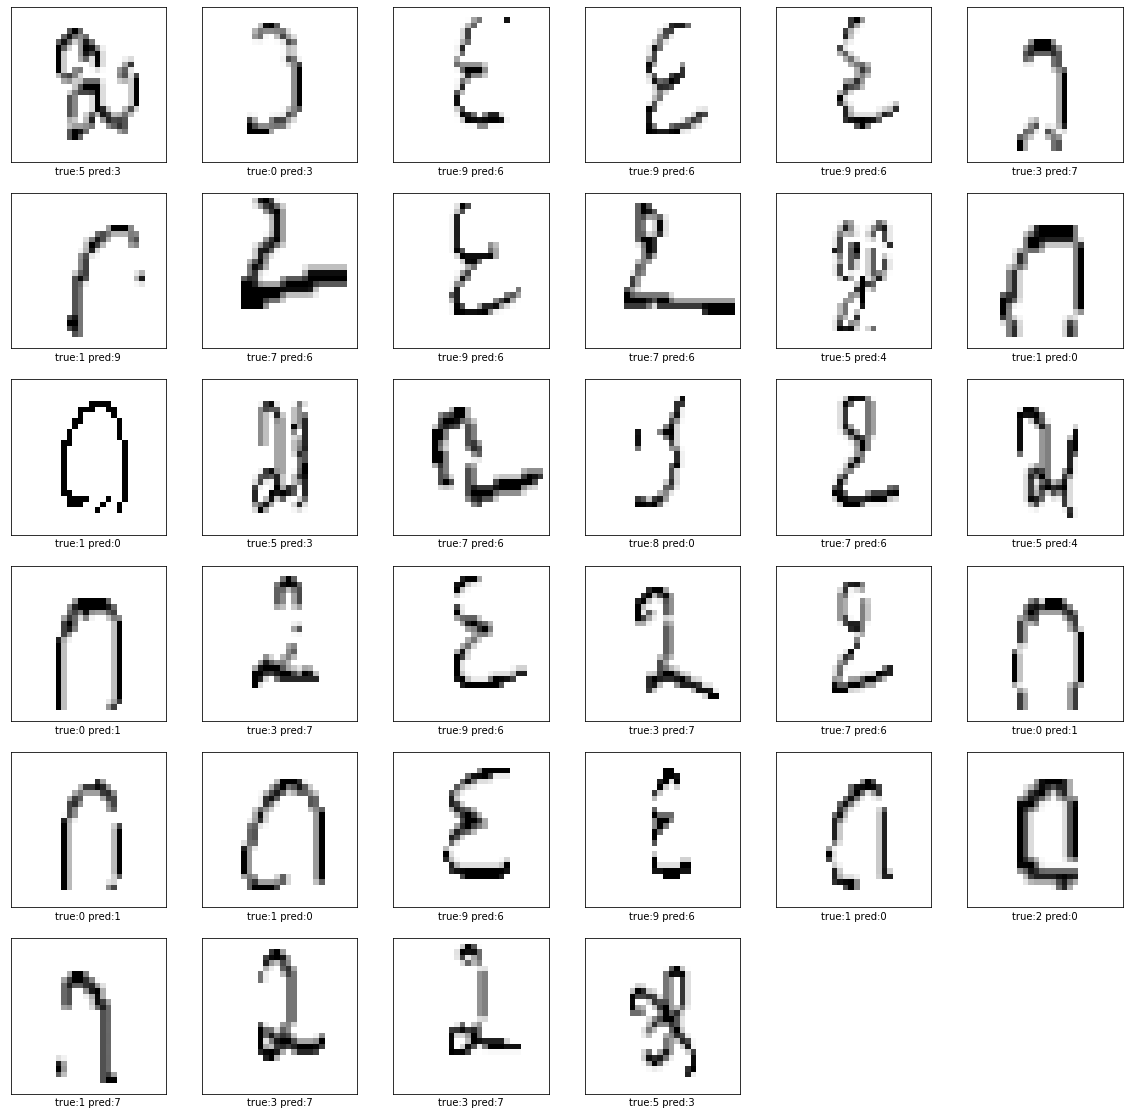

In [157]:
print_misclssified(predictions, test_labels)